# Python tutorial: image recovery with proximal tools

1. [Introduction](#Introduction)

2. [Degradation model](#Degradation-model) 

3. [Problem formulation](#Problem-formulation)

5. [Regularization](#Regularization)

 1. [Total variation](#Total-variation)
 
 2. [Structure tensor](#Structure-tensor)

## Introduction

This tutorial describes how to tackle optimization problems with the *forward-backward primal-dual algorithm (FBPD)*, which is able to

$$
\operatorname*{minimize}_{x\in\mathbb{R}^N} \; f(x) + g(x) + h(Fx)
$$

where $f \in \Gamma_0(\mathbb{R}^N)$, $g \in \Gamma_0(\mathbb{R}^N)$ with $\beta$-Lipschitz continuous gradient for some $\beta>0$, and $F \in \mathbb{R}^{M\times N}$ and $h\in \Gamma_0(\mathbb{R}^M)$.

Under some technical assumptions, it can be show that the sequence $(x^{[i]})_{i\in\mathbb{N}}$ generated by

$$
\left\lfloor
\begin{aligned}
x^{[i+1]} &= \operatorname{prox}_{\tau \, f} \Big(x^{[i]} - \tau \big(\nabla g(x^{[i]}) + F^\top y^{[i]}\big)\Big)\\[0.5em]
y^{[i+1]} &= \operatorname{prox}_{\sigma \, h^*} \Big( y^{[i]}+\sigma \, F\big(2x^{[i+1]}-x^{[i]}\big)\Big)
\end{aligned}
\right.
$$

converges to a solution to the above problem, provided that
 - $(x^{[0]},y^{[0]}) \in \mathbb{R}^N \times \mathbb{R}^M$
 - $\tau>0$ and $\sigma>0$ are such that $\tau \left(\frac{\beta}{2} + \sigma \|F^\top F\|\right) < 1$
 
A generic implementation of FBPD is given below (the function inputs will be clarified later).

In [1]:
import numpy as np
import time as time

# Default inputs of the FBPD function
class EmptyFunction:
    beta=1 
    def __call__(self, x):    return 0    # return the value of the function evaluated a x
    def grad(self, x):     return 0
    def prox(self, x): return x
    def dir_op(self, x):   return x
    def adj_op(self, x):   return x
    
    

# Default algorithmic parameters: 'tol' and maximum number of iterations
opt_= {'tol': 1e-4, 'iter': 500}

def FBPD(x_init, f=EmptyFunction(), g=EmptyFunction(), h=EmptyFunction(), opt=opt_):

    # algorithmic parameters
    tol      = opt['tol']
    max_iter = opt['iter']
    
    # step-sizes
    tau   = 2.0 / (g.beta + 2.0)
    sigma = (1.0/tau - g.beta/2.0) / h.beta

    # initialization
    x = x_init
    y = h.dir_op(x)

    print('Running FBPD...')
    
    timing = []
    criter = []

    # algorithm loop
    stop=False
    it=0
    while (it < max_iter) and (not stop):
    
        t = time.time()
    
        # primal forward-backward step
        x_old = x
        x = x - tau * ( g.grad(x) + h.adj_op(y) )
        x = f.prox(x)
    
        # dual forward-backward step
        y = y + sigma * h.dir_op(2*x - x_old)
        y = y - sigma * h.prox(y/sigma, 1/sigma)

        # time and criterion
        timing.append( time.time() - t)
        criter.append( f(x) + g(x) + h(h.dir_op(x)) )
           
        # stopping rule
        if np.linalg.norm(x - x_old) < tol * np.linalg.norm(x_old) and it > 10:
           stop=True
           
        it+=1
        print(str(it)+'out of'+str(max_iter)+'iterations')

    timing = np.cumsum(timing)
    
    return x, it, timing, criter

## Degradation model

The goal of *image recovery* is to restore the visual content of a corrupted image through the inversion of the corresponding degradation process. In this context, a popular task consists of recovering an image $\overline{x} \in \mathbb{R}^N$ as close as possible to some observations $z \in \mathbb{R}^K$ generated as 


$$
z = A\overline{x} + b
$$

where $A \in \mathbb{R}^{K\times N}$ is a known linear degradation, and $b \in \mathbb{R}^K$ is a realization of zero-mean white Gaussian noise.

For the purpose of this tutorial, the degraded image is generated as follows (with $K=N$).

Text(0.5, 1.0, 'Noisy image')

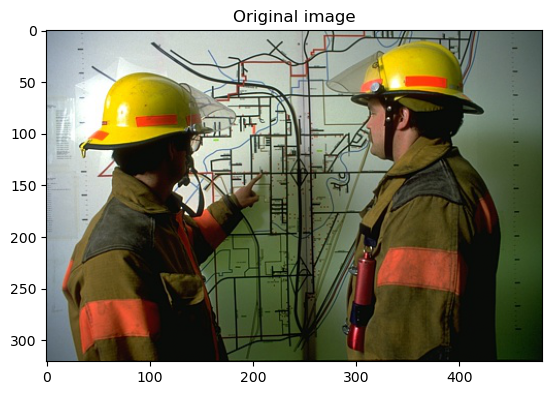

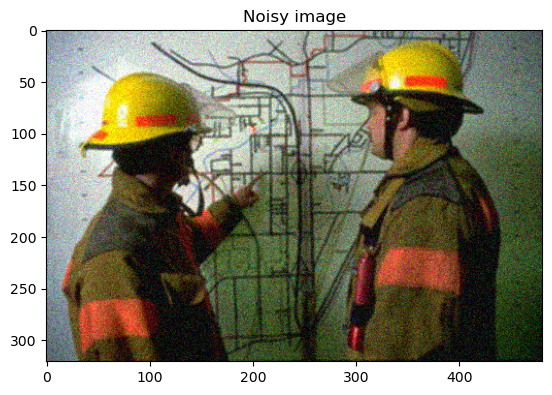

In [2]:
from scipy.ndimage import uniform_filter
import matplotlib.pyplot as plt
%matplotlib inline 

# ! Uncomment the next line and CHANGE THE DIRECTORY ACCORDING TO THE PATH OF THE IMAGE
# %cd "path toward the file firemen.jpg"   

x_bar = plt.imread('firemen.jpg')
x_bar = x_bar.astype(np.float64)

# blur operator
psf = (3, 3, 1)

# noisy image
z = uniform_filter(x_bar, psf) + 20 * np.random.randn(*x_bar.shape);

# visualization
plt.imshow(x_bar/255)
plt.title('Original image')
plt.figure()
plt.imshow(np.clip(z/255,0,1))
plt.title('Noisy image')

## Problem formulation

To recover $\overline{x}$ from $z$, one can follow a variational approach that aims at

$$
\operatorname*{minimize}_{x\in[0,255]^N} \quad \underbrace{\frac{1}{2}\|Ax-z\|_2^2}_{\textrm{Data fidelity}} \quad + \underbrace{h(F x)}_{\textrm{Regularization}}
$$

This formulation reverts to the general convex optimization problem given in [Introduction](#Introduction) by setting $f(x) = \iota_{[0,255]^N}(x)$ and $g(x) = \frac{1}{2}\|Ax-z\|_2^2$.
 
As for the data fidelity term, FBPD needs the following information:

 - $\operatorname{prox}_{\tau \, f}(x) = P_{[0,255]^N}(x)$
 
 
 - $\nabla g(x) = A^\top(Ax-z)$
 
 
 - $\beta = \|A\|^2$

This is illustrated in the code below.

In [3]:
from proxop import BoxConstraint

class LeastSquares:
    
    def __init__(self, z=None, psf=None):
        self.z    = z
        self.psf  = psf
        self.beta = np.prod(psf)
        
    def A_dir(self, x):
        return uniform_filter(x, self.psf)
    
    def A_adj(self, x):
        return uniform_filter(x, self.psf);   # WARNING: filter dimensions must be odd
    
    def grad(self, x):
        return self.A_adj( self.A_dir(x) - self.z )
    
    def __call__(self, x):
        p = self.A_dir(x)
        return np.sum(np.square(p-z))

# constraint
f = BoxConstraint(0, 255)

# data fidelity
g = LeastSquares(z, psf)

## Regularization

Various forms of regularization arise with specific choices of $F$ and $h$, as discussed next.

### Total variation

The *total variation (TV)* is defined as:

$$
\operatorname{TV}(x) = \lambda \sum_{\ell=1}^N \left(\big|x^{(\ell)}-x^{(n_{\ell,1})}\big|^2 + \big|x^{(\ell)}-x^{(n_{\ell,2})}\big|^2\right)^{1/2}
$$

where $\lambda>0$ and $(n_{\ell,1},n_{\ell,2})\in\{1,\dots,N\}^2$ denote the positions of the horizontal/vertical nearest neighbors of $x^{(\ell)}$. 

This penalty can be plugged into [Problem formulation](#Problem-formulation) by setting:


$$
y = F x = 
\left[
\begin{aligned}
&x^{(1)}-x^{(n_{1,1})}\\
&x^{(1)}-x^{(n_{1,2})}\\
&\quad\;\; \vdots\\
&x^{(N)}-x^{(n_{N,1})}\\
&x^{(N)}-x^{(n_{N,2})}\\
\end{aligned}
\right]
\begin{aligned}
&\left.\vphantom{
\begin{aligned}
&x^{(1)}-x^{(n_{1,1})}\\
&x^{(1)}-x^{(n_{1,2})}\\
\end{aligned}
}\right\} \; y_1\in\mathbb{R}^2\\
&\qquad\vdots\\
&\left.\vphantom{
\begin{aligned}
&y_{K-1} \tilde{x_{K-1}}\\
&x^{(N)}-x^{(n_{N,2})}\\
\end{aligned}
}\right\} \; y_N\in\mathbb{R}^2\\
\end{aligned}
\qquad\textrm{and}\qquad
h(y) = \sum_{\ell=1}^N \lambda \|y_\ell\|_2.
$$

Consequently, FBPD needs the following information: 
 
 - $F$ and $F^\top$
 
 
 - $\|F^\top F\| = 8$
 
 
 - $\operatorname{prox}_{\gamma \, h}(y) = \Big(\operatorname{prox}_{\gamma \, \lambda\|\cdot\|_2}(y_\ell)\Big)_{1\le\ell\le N}$

Let's start with the implementation of $F$, $F^\top$ and $\operatorname{prox}_h$.

In [4]:
from proxop import L2Norm

def hor_forward(x):
    """ Horizontal forward finite differences (with Neumann boundary conditions) """
    hor = np.zeros_like(x)
    hor[:,:-1,:] = x[:,1:,:] - x[:,:-1,:]
    return hor

def ver_forward(x):
    """ Vertical forward finite differences (with Neumann boundary conditions) """
    ver = np.zeros_like(x)
    ver[:-1,:,:] = x[1:,:,:] - x[:-1,:,:]
    return ver

def hor_backward(x):
    """ Horizontal backward finite differences (with Neumann boundary conditions) """
    Nr, Nc, Nb = x.shape
    zer = np.zeros((Nr,1,Nb))
    xxx = x[:,:-1,:]
    return np.concatenate((zer,xxx), 1) - np.concatenate((xxx,zer), 1)

def ver_backward(x):
    """ Vertical backward finite differences (with Neumann boundary conditions) """
    Nr, Nc, Nb = x.shape
    zer = np.zeros((1,Nc,Nb))
    xxx = x[:-1,:,:]
    return np.concatenate((zer,xxx), 0) - np.concatenate((xxx,zer), 0)


class TotalVariation(L2Norm):

    beta = 8
    
    def __init__(self, lam):
        self.lam = lam     # hyperparemter lambda
        super().__init__(axis=3)

    def prox(self, x, gamma):
        return super().prox(x, self.lam*gamma)
    
    def __call__(self, x):
        return self.lam*super().__call__(x)

    def dir_op(self, x):
        h = hor_forward(x)
        v = ver_forward(x)
        return np.stack((h,v), 3)
    
    def adj_op(self, y):
        h = hor_backward( y[:,:,:,0] )
        v = ver_backward( y[:,:,:,1] )
        return h + v

The implementation of $\operatorname{prox}_h$ is inherited from the `L2_Norm` class, and it uses the fact that the method `dir_op()` returns a 4D array in which the *gradient vector* of each pixel is stored along the 4th dimension.

Let's continue with the definition of TV regularization.

In [5]:
# hyperparameter
lambda_ = 5

# regularization
h = TotalVariation(lambda_)

The information needed by FBPD is now complete, and the optimization method can be executed.

Running FBPD...
1out of200iterations
2out of200iterations
3out of200iterations
4out of200iterations
5out of200iterations
6out of200iterations
7out of200iterations
8out of200iterations
9out of200iterations
10out of200iterations
11out of200iterations
12out of200iterations
13out of200iterations
14out of200iterations
15out of200iterations
16out of200iterations
17out of200iterations
18out of200iterations
19out of200iterations
20out of200iterations
21out of200iterations
22out of200iterations
23out of200iterations
24out of200iterations
25out of200iterations
26out of200iterations
27out of200iterations
28out of200iterations
29out of200iterations
30out of200iterations
31out of200iterations
32out of200iterations
33out of200iterations
34out of200iterations
35out of200iterations
36out of200iterations
37out of200iterations
38out of200iterations
39out of200iterations
40out of200iterations
41out of200iterations
42out of200iterations
43out of200iterations
44out of200iterations
45out of200iterations
46o

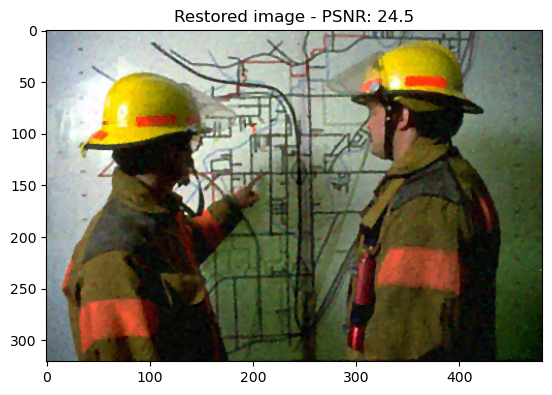

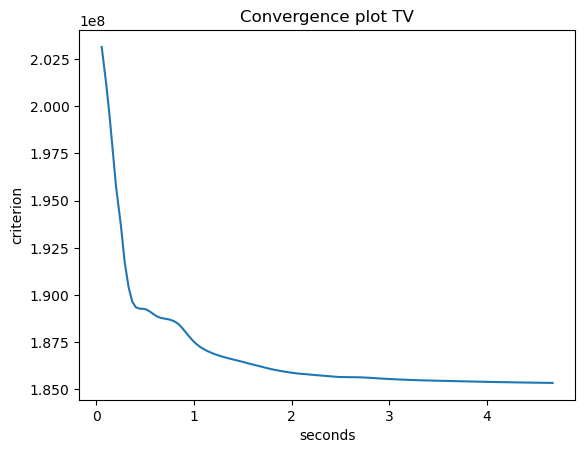

In [6]:
# minimization
opt_= {'tol': 1e-4, 'iter': 200}
x, it, time_tv, crit_tv = FBPD(z, f, g, h, opt_)

# PSRN
psnr = 10 * np.log10( 255*255 / np.mean(np.square(x-x_bar)) )

# visualization
plt.imshow(x/255); 
plt.title( 'Restored image - PSNR: ' + str(np.round(psnr,2)) )
plt.figure()
plt.plot(time_tv, crit_tv) 
plt.title('Convergence plot TV')
plt.xlabel('seconds')
plt.ylabel('criterion')
plt.savefig("convergence_TV.jpg")

In [10]:
plt.imsave("restored_image_TV.jpg",np.clip(x/255,0,1))
plt.imsave("blurred_image.jpg",np.clip(z/255,0,1))

### Structure tensor

In the previous example, the regularization is applied separately to each color channel of the image to be restored. The *structure tensor (ST)* is a natural extension of TV that allows one to process the channels jointly. Assume that the sought image $x$ is composed by three channels (red, blue, and greed):

$$
x = 
\begin{bmatrix}
x_1\\ x_2\\ x_3
\end{bmatrix}
$$

with $x_j\in\mathbb{R}^Q$ for every $j\in\{1,2,3\}$, and $N=3Q$. The ST regularization is defined as:


$$
\operatorname{ST}(x) = \lambda \sum_{\ell=1}^Q \left\|\begin{bmatrix} 
x_1^{(\ell)}-x_1^{(n_{\ell,1})} & x_2^{(\ell)}-x_2^{(n_{\ell,1})} & x_3^{(\ell)}-x_3^{(n_{\ell,1})} \\
x_1^{(\ell)}-x_1^{(n_{\ell,2})} & x_2^{(\ell)}-x_2^{(n_{\ell,2})} & x_3^{(\ell)}-x_3^{(n_{\ell,2})}
\end{bmatrix}\right\|_*
$$

where $\lambda>0$ and $\|\cdot\|_*$ denotes the nuclear norm. 

This penalty can be plugged into [Problem formulation](#Problem-formulation) by setting:


$$
Y = F x = 
\left[
\begin{aligned}
&x_1^{(1)}-x_1^{(n_{1,1})} &&x_2^{(1)}-x_2^{(n_{1,1})} &&x_3^{(1)}-x_3^{(n_{1,1})} \\
&x_1^{(1)}-x_1^{(n_{1,2})} &&x_2^{(1)}-x_2^{(n_{1,2})} &&x_3^{(1)}-x_3^{(n_{1,2})} \\
&\quad\;\; \vdots &&\quad\;\; \vdots&&\quad\;\; \vdots\\
&x_1^{(Q)}-x_1^{(n_{Q,1})} &&x_2^{(Q)}-x_2^{(n_{Q,1})} &&x_3^{(Q)}-x_3^{(n_{Q,1})} \\
&x_1^{(Q)}-x_1^{(n_{Q,2})} &&x_2^{(Q)}-x_2^{(n_{Q,2})} &&x_3^{(Q)}-x_3^{(n_{Q,2})} \\
\end{aligned}
\right]
\begin{aligned}
&\left.\vphantom{
\begin{aligned}
&x^{(1)}-x^{(n_{1,1})}\\
&x^{(1)}-x^{(n_{1,2})}\\
\end{aligned}
}\right\} \; Y_1\in\mathbb{R}^{2\times3}\\
&\qquad\vdots\\
&\left.\vphantom{
\begin{aligned}
&x^{(Q)}-x^{(n_{Q,1})}\\
&x^{(Q)}-x^{(n_{Q,2})}\\
\end{aligned}
}\right\} \; Y_Q\in\mathbb{R}^{2\times3}\\
\end{aligned}
\qquad\textrm{and}\qquad
h(Y) = \sum_{\ell=1}^Q \lambda \|Y_\ell\|_*.
$$

Consequently, FBPD needs the following information: 
 
 - $F$ and $F^\top$
 
 
 - $\|F^\top F\| = 8$
 
 
 - $\operatorname{prox}_{\gamma \, h}(Y) = \Big(\operatorname{prox}_{\gamma \, \lambda\|\cdot\|_*}(Y_\ell)\Big)_{1\le\ell\le Q}$

Let's start with the implementation of $F$ and its adjoint $F^\top$.

In [11]:
from proxop import NuclearNorm 

class StructureTensor(NuclearNorm):
    def __init__(self, lam):
        self.beta = 8
        self.lam = lam  # hyperparameter lambda
        super().__init__()
    
    def prox(self, x, gamma):
        return super().prox(x, self.lam*gamma)
    
    def __call__(self, x):
        return self.lam*super().__call__(x)
    
    # utility functions
    def _pack(self,x):
        sz=np.shape(x)
        return np.reshape( np.transpose(x, (2,0,1)), (1, sz[2], sz[0], sz[1]) )

    def _unpack(self,y,i):
        sz=np.shape(y)
        #np.transpose( np.reshape(y[i,...], (sz[1], sz[2], sz[3])), (1,2,0))
        return np.transpose( y[i,...], (1,2,0) )
    
    def dir_op(self, x):
        h = self._pack(hor_forward(x))
        v = self._pack(ver_forward(x))
        return np.concatenate((h,v), 0)
    
    def adj_op(self, y):
        h = hor_backward( self._unpack( y, 0) )
        v = ver_backward( self._unpack( y, 1) )
        return h + v

Let's continue with the implementation of $\operatorname{prox}_h$. 

Note that `h.dir_op` generates a 4D matrix in which the *gradient matrix* of each position is stored on the 1st and 2nd dimensions.

In [12]:
# regularization parameter
lambda_ = 7
h=StructureTensor(lam=lambda_)

The information needed by FBPD is now complete, and the optimization method can be executed.

Running FBPD...
1out of100iterations
2out of100iterations
3out of100iterations
4out of100iterations
5out of100iterations
6out of100iterations
7out of100iterations
8out of100iterations
9out of100iterations
10out of100iterations
11out of100iterations
12out of100iterations
13out of100iterations
14out of100iterations
15out of100iterations
16out of100iterations
17out of100iterations
18out of100iterations
19out of100iterations
20out of100iterations
21out of100iterations
22out of100iterations
23out of100iterations
24out of100iterations
25out of100iterations
26out of100iterations
27out of100iterations
28out of100iterations
29out of100iterations
30out of100iterations
31out of100iterations
32out of100iterations
33out of100iterations
34out of100iterations
35out of100iterations
36out of100iterations
37out of100iterations
38out of100iterations
39out of100iterations
40out of100iterations
41out of100iterations
42out of100iterations
43out of100iterations
44out of100iterations
45out of100iterations
46o

Text(0, 0.5, 'criterion')

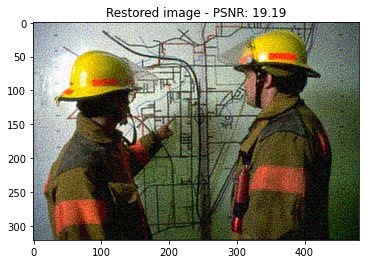

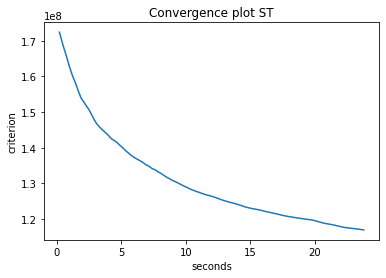

In [23]:
# minimization
opt_= {'tol': 1e-4, 'iter': 100}
x, it, time_st, crit_st = FBPD(z, f, g, h, opt_)

# PSRN
psnr = 10 * np.log10( 255**2 / np.mean((x-x_bar)**2))

# visualization
plt.imshow(x/255);
plt.title( 'Restored image - PSNR: ' + str(np.round(psnr,2)) )
plt.figure()
plt.plot(time_st, crit_st) 
plt.title('Convergence plot ST')
plt.xlabel('seconds')
plt.ylabel('criterion')

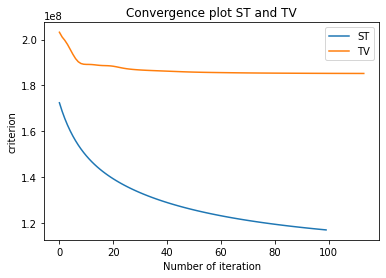

In [34]:
plt.plot(np.arange(len(crit_st)), crit_st, label='ST') 
plt.plot(np.arange(len(crit_tv)), crit_tv, label='TV') 
plt.title('Convergence plot ST and TV')
plt.legend()
plt.xlabel('Number of iteration')
plt.ylabel('criterion')
plt.show()

In [27]:
plt.imsave("restored_image_ST.png",np.clip(x/255,0,1))